In [ ]:
!python --version

Python 3.7.12


In [ ]:
#install python 3.9
!sudo apt-get update -y
!sudo apt-get install python3.9

#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

#check python version
!python --version

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [828 kB]
Hit:13 http://ppa.laun

In [ ]:
# !sudo apt -y install python3-pip
# !sudo apt install python3.9-distutils
# !python -m pip install --upgrade pip
# !apt install python3.9-venv

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hw_abt_2_byuser.csv to hw_abt_2_byuser.csv
Saving hw_abt_2_bybucket.csv to hw_abt_2_bybucket.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, kstest, shapiro
from scipy.stats import ttest_ind, mannwhitneyu

In [ ]:
import scipy
scipy.__version__

'1.4.1'

In [ ]:
data_bucket = pd.read_csv('hw_abt_2_bybucket.csv', sep='\t')
data_user = pd.read_csv('hw_abt_2_byuser.csv', sep='\t')

###### Посмотрим на данные
   * metric_value – сумма целевых действий пользователей в рамках bucket’а – например, просмотров рекламного баннера, телефона на сайте classified-сервиса или покупок в retail/FMCG;
* users – кол-во пользователей, совершивших целевое действие,
* visits – кол-во целевых сессий,
* churn_users и churn_visits – кол-во пользователей в рамках bucket’а, отказавшихся сделать заказ, и сессий, не закончившихся успешным целевым действием

In [ ]:
data_user.head()

,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,0,8,6630.000,0,0,0,8,A
1,1,13,6933.976,0,0,1,6,B
2,2,10,8261.976,1,10,1,8,B
3,3,4,5522.000,1,9,1,7,A
4,4,16,5075.976,1,6,0,8,B


In [ ]:
print('unique users:', data_user['Unnamed: 0'].unique().shape[0])

unique users: 5000


In [ ]:
data_user.groupby('group').describe()

Unnamed: 0                                 ... churn_visits               
           count         mean          std  min  ...          25%  50%  75%  max
group                                            ...                            
A         2451.0  2513.987760  1442.223383  0.0  ...          6.0  7.0  9.0  9.0
B         2549.0  2485.569243  1444.911607  1.0  ...          6.0  7.0  9.0  9.0

[2 rows x 56 columns]

In [ ]:
data_user[(data_user['churn_users'] > 0) & (data_user['users'] == 0)].groupby('group').describe()

Unnamed: 0                                  ... churn_visits               
           count         mean          std   min  ...          25%  50%  75%  max
group                                             ...                            
A          621.0  2427.072464  1508.628688  13.0  ...          6.0  7.0  9.0  9.0
B         1026.0  2591.862573  1436.581671   1.0  ...          6.0  7.0  9.0  9.0

[2 rows x 56 columns]

#### 1. visits = 0, users = 0, но metric_value > 0
Возможно:
 * 1. совершил ц.д. во время эксперимента и metric_value зафиксировалось, но запись в user и visits произошла после эксперимента.
  Например сделал заказ, оплатил (при этом users и visits устанавливаются в 1 после получения товара), но получил после эксперимента.
 * 2. Или же совершил возврат во время эксперимента, но в metric_value это не учитывалось, что указывает на неправильную работу по подсчету metric_value. Тогда churn_users = 1

Если верно 2., то нужно ли учитывать таких пользователей при проведении теста для metric_value?

In [ ]:
data_user[(data_user['visits'] == 0) & (data_user['users'] == 0)].head()

,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,0,8,6630.000,0,0,0,8,A
1,1,13,6933.976,0,0,1,6,B
5,5,2,8539.000,0,0,0,8,A
6,6,8,5714.000,0,0,0,7,A
7,7,3,7330.000,0,0,0,6,A


In [ ]:
d = data_user[(data_user['visits'] == 0) & (data_user['users'] == 0) & (data_user['churn_users'] == 1)]
print(d.shape)
d.head()

(1647, 8)


,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
1,1,13,6933.976,0,0,1,6,B
12,12,13,6812.976,0,0,1,8,B
13,13,1,6057.000,0,0,1,6,A
15,15,3,9056.000,0,0,1,5,A
17,17,9,7309.976,0,0,1,8,B


#### 2. users = 1 и churn_users = 1
   Для одного и того же пользователя, это можно интерпретировать следующим образом:
    у пользователя был минимум 1 успешный заказ в рамках периода эксперимента, но так же были и визиты/заходы в приложение, при которых он заказ не сделал;


In [ ]:
data_user[(data_user['users'] == 1) & (data_user['churn_users'] == 1)].head()

,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
2,2,10,8261.976,1,10,1,8,B
3,3,4,5522.000,1,9,1,7,A
8,8,2,6759.000,1,4,1,7,A
16,16,1,7227.000,1,12,1,7,A
18,18,12,7254.976,1,22,1,6,B


#### 2. visits = 0, но users = 1
пользователь совершил целевое действие,
 но отметки о том, что у него была сессия, окончившаяся этим самым действием, нет.
Возможно потому, что он совершил ц.д., но сессия по каким-то причинам осталась открытой.

In [ ]:
data_user[(data_user['visits'] == 0) & (data_user['users'] > 0)]

,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
27,27,15,5181.976,1,0,0,9,B
53,53,2,5989.000,1,0,1,6,A
71,71,8,8102.000,1,0,0,5,A
89,89,16,7727.976,1,0,1,5,B
161,161,5,8057.000,1,0,0,6,A
...,...,...,...,...,...,...,...,...
4915,4915,8,7650.000,1,0,1,7,A
4924,4924,8,5538.000,1,0,0,9,A
4960,4960,11,7034.976,1,0,1,7,B
4968,4968,2,7295.000,1,0,0,9,A


#### 3. churn_visits = 0, но churn_users = 1
 т.е. пользователь отменил заказ, но при этом сессия не учтена как не закончившаяся успешным целевым действием.
  * Возможно потому, что в рамках одной сессии он мог отказаться, но затем совершить заказ (ц.д.), поэтому сессия не учтена как незакончившаяся цд-ем.
  * В двух последних строках, возможно, создал аккаунт и удалил

In [ ]:
data_user[(data_user['churn_visits'] == 0) & (data_user['churn_users'] > 0)]

,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
514,514,7,5413.000,1,0,1,0,A
1004,1004,15,6687.976,1,1,1,0,B
1765,1765,1,6097.000,1,3,1,0,A
2153,2153,11,4508.976,0,0,1,0,B
4700,4700,11,5684.976,0,0,1,0,B


#### 4. churn_visits > 0, но churn_users = 0
  Мог заходить на "сайт" и ничего не делать (users=0, visits=0) или делать без отказов (users=1, visits>=0).

In [ ]:
data_user[(data_user['churn_visits'] > 0) & (data_user['churn_users'] == 0)].head()

,Unnamed: 0,group_id,metric_value,users,visits,churn_users,churn_visits,group
0,0,8,6630.000,0,0,0,8,A
4,4,16,5075.976,1,6,0,8,B
5,5,2,8539.000,0,0,0,8,A
6,6,8,5714.000,0,0,0,7,A
7,7,3,7330.000,0,0,0,6,A


In [ ]:
A = data_user[data_user['group'] == 'A']
B = data_user[data_user['group'] == 'B']

In [ ]:
A.shape, B.shape

((2451, 8), (2549, 8))

In [ ]:
def show_hist(A, B, feature):
    plt.figure(figsize=(10, 8))
    A[feature].hist( density=True, bins=int(np.sqrt(A.shape[0])), label='A')
    B[feature].hist(density=True, alpha=0.6, bins=int(np.sqrt(A.shape[0])), label='B')

    plt.axvline(x=A[feature].mean(), color='r', label='A mean')
    plt.axvline(x=B[feature].mean(), color='g', label='B mean')

    plt.axvline(x=A[feature].median(), color='yellow', label='A median')
    plt.axvline(x=B[feature].median(), color='indigo', label='B median')

    plt.xlabel(feature)

    plt.legend()
    plt.show()

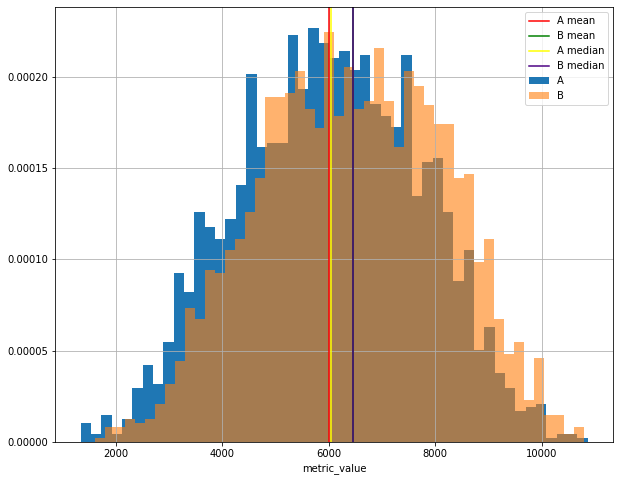

In [ ]:
show_hist(A, B, 'metric_value')

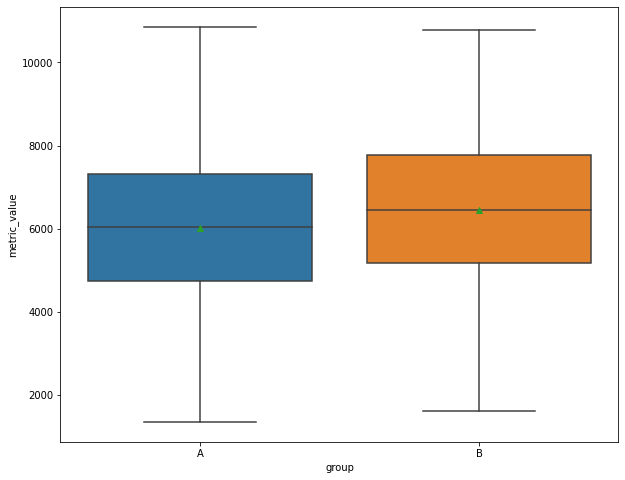

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='group', y='metric_value',
            data=data_user, showmeans=True)

#### 1. Проверка распределения на нормальность
Проверим распределения на нормальность, чтобы узнать, можно ли использовать параметрические критерии.

In [ ]:
alpha = 0.05

##### 1.1 Тест Колмогорова-Смирнова
Изначально писал в локальном jupyter-notebook
При переносе в colab оказалось, что установленная на нем версия scipy.kstest
не принимает np.array в качестве аргумента, пришлось закомментировать и написать 'norm'

In [ ]:
def check_normal_kol(A, B, feature):
    res_cont = kstest(A[feature], 'norm')
                #  norm.rvs(loc=A[feature].mean(), scale=A[feature].std(), size=10000))
    print(res_cont)
    print('Distribution of control group is {}normal\n'.format( {True:'not ', False:''}[res_cont[1] < alpha]))

    res_test = kstest(B[feature], 'norm')
                #  norm.rvs(loc=B[feature].mean(), scale=B[feature].std(), size=10000))
    print(res_test)
    print('Distribution of test group is {}normal'.format( {True:'not ', False:''}[res_test[1] < alpha]))

In [ ]:
check_normal_kol(A, B, 'metric_value')

KstestResult(statistic=1.0, pvalue=0.0)
Distribution of control group is not normal

KstestResult(statistic=1.0, pvalue=0.0)
Distribution of test group is not normal


##### 1.2 Критерий Шапиро-Уилкса

In [ ]:
def check_normal_shapiro(A, B, feature):
    res_cont = shapiro(A[feature])
    print(res_cont)
    print('Distributions of control group is {}normal\n'.format( {True:'not ', False:''}[res_cont[1] < alpha]))

    res_test = shapiro(B[feature])
    print(res_test)
    print('Distributions of test group is {}normal'.format( {True:'not ', False:''}[res_test[1] < alpha]))

In [ ]:
check_normal_shapiro(A, B, 'metric_value')

(0.9951456189155579, 3.546447828739474e-07)
Distributions of control group is not normal

(0.9923585057258606, 2.4686641619808825e-10)
Distributions of test group is not normal


Результат критерия Шапиро-Уилкса предпочтительней, т.к. он обладает большей мощностью (меньше вероятность ошибочно принять H0 - что распределение нормальное).
Оба распределения не являются нормальными, поэтому будем использовать непараметрические критерии.

#### 2 Проверка на равенство дисперсий
  Для проверки используем критерий Левена, т.к. он менее чувствителен к отклонению распределения от нормального


##### 2.1 Критерий Левена

In [ ]:
from scipy.stats import f_oneway, bartlett, levene
def levene_test(df1, df2, alpha=0.05):
    st = levene(df1, df2)
    print('Variances of distributions is {}equal\n'.format({True:'not ', False:''}[st[1] < alpha]))

In [ ]:
levene_test(A['metric_value'], B['metric_value'])

Variances of distributions is equal



#### 3. Проверка на стат знчимость различий
Используем U-критерий Манна-Уитни, т.к. он не требует нормальность и однородность дисперсий

##### 3.1 U-Критерий Манна-Уитни

In [ ]:
st = mannwhitneyu(A.metric_value.unique(), B.metric_value.unique())
print(st)
print('Diffs is {}significant\n'.format( {False:'not ',
                                          True:''}[st[1] < alpha]))

MannwhitneyuResult(statistic=1829355.0, pvalue=1.8008542516108292e-15)
Diffs is significant



Получили статистически значимое различие

In [ ]:
print('difference:', np.round(B.metric_value.mean() - A.metric_value.mean()))
print(f'observed effect: {np.round(100 * (B.metric_value.mean() - A.metric_value.mean()) / A.metric_value.mean())} %')

difference: 433.0
observed effect: 7.0 %


Получили статистически значимый эффект увеличения metric_value на 7% (на 433)

Просто интересно, что выдаст t test

In [ ]:
t_st = ttest_ind(A.metric_value, B.metric_value)
print(t_st)
print('Diffs is {}significant\n'.format( {False:'not ',
                                          True:''}[t_st[1] < alpha]))

Ttest_indResult(statistic=-8.943431681351806, pvalue=5.219043548940759e-19)
Diffs is significant



#### 4 Расчет размера выборки

In [ ]:
from statsmodels.stats.power import TTestIndPower

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
effect = 0.07
alpha = 0.05
power = 0.8
analysis = TTestIndPower()
# result = analysis.solve_power(effect, power=power, ratio=1.0, alpha=alpha)
peop_per_day = data_user.shape[0] / 14


print(f'A: {A.shape[0]}, B: {B.shape[0]}')

for eff in [7, 8, 10]:
    result = analysis.solve_power(eff/100, power=power, ratio=1.0, alpha=alpha)
    cnt = int(result)+1
    a = cnt - A.shape[0]
    b = cnt - B.shape[0]

    print(f'effect {eff}%')
    print(f'  Нужно набрать: {cnt} человек для каждой группы')
    if a >= 0:
      print(f'  Для контрольной нужно набрать еще: {a}')
    if b >= 0:
      print(f'  Для экспериментальной нужно набрать еще: {b}')
    print(f'  Для нового набора понадобится {int(2*cnt / peop_per_day)+1} дней')
    if a >= 0 or b >= 0:
      print(f'  Для  донабора понадобится {int(max(a, b) / peop_per_day)+1} дней')

A: 2451, B: 2549
effect 7%
  Нужно набрать: 3205 человек для каждой группы
  Для контрольной нужно набрать еще: 754
  Для экспериментальной нужно набрать еще: 656
  Для нового набора понадобится 18 дней
  Для  донабора понадобится 3 дней
effect 8%
  Нужно набрать: 2454 человек для каждой группы
  Для контрольной нужно набрать еще: 3
  Для нового набора понадобится 14 дней
  Для  донабора понадобится 1 дней
effect 10%
  Нужно набрать: 1571 человек для каждой группы
  Для нового набора понадобится 9 дней


#####  Проведем тест без пользователей с users=0, visits=0, churn_users=1

In [ ]:
g = iter(data_user[(data_user['visits'] == 0) & (data_user['users'] == 0)].groupby('group'))
_, A = next(g)
_, B = next(g)

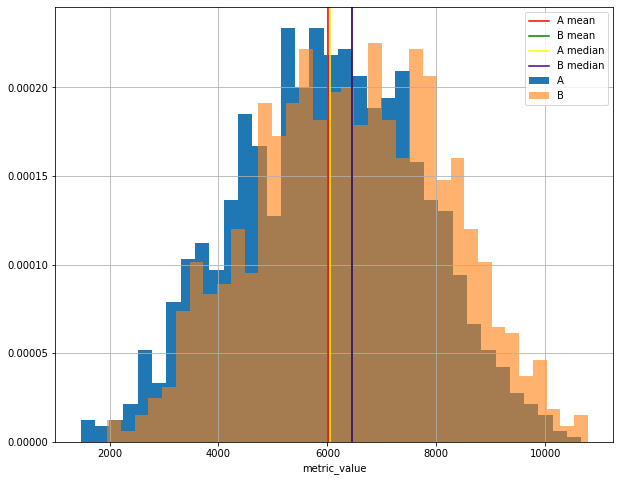

In [ ]:
show_hist(A, B, 'metric_value')

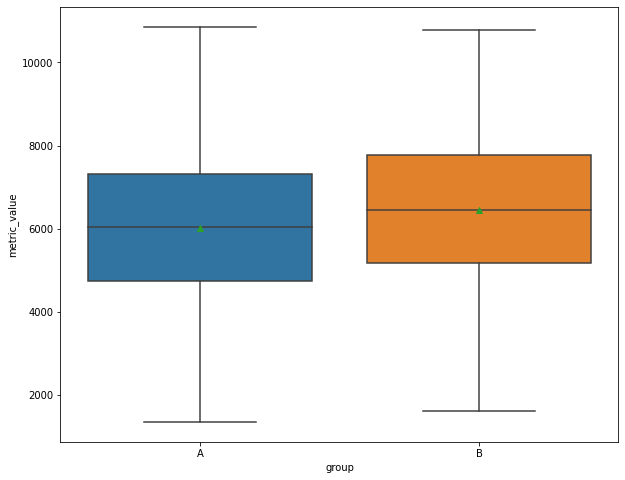

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='group', y='metric_value',
            data=data_user, showmeans=True)

In [ ]:
check_normal_kol(A, B, 'metric_value')
check_normal_shapiro(A, B, 'metric_value')

levene_test(A['metric_value'], B['metric_value'])

st = mannwhitneyu(A.metric_value.unique(), B.metric_value.unique())
print(st)
print('Diffs is {}significant\n'.format( {False:'not ',
                                          True:''}[st[1] < alpha]))

print('difference:', np.round(B.metric_value.mean() - A.metric_value.mean()))
print(f'observed effect: {np.round(100 * (B.metric_value.mean() - A.metric_value.mean()) / A.metric_value.mean())} %')

KstestResult(statistic=1.0, pvalue=0.0)
Distribution of control group is not normal

KstestResult(statistic=1.0, pvalue=0.0)
Distribution of test group is not normal
(0.9958456158638, 0.0017358018085360527)
Distributions of control group is not normal

(0.9931009411811829, 1.0515710528125055e-05)
Distributions of test group is not normal
Variances of distributions is equal

MannwhitneyuResult(statistic=568116.0, pvalue=5.401536387296929e-09)
Diffs is significant

difference: 432.0
observed effect: 7.0 %


Получил похожие результаты

### Посмотрим на агрегированные в рамках бакета метрики

1. Кол-во отказов

In [ ]:
data_bucket.loc[:9, 'group'] = 'A'
data_bucket.loc[9:, 'group'] = 'B'

A = data_bucket[data_bucket['group'] == 'A']
B = data_bucket[data_bucket['group'] == 'B']

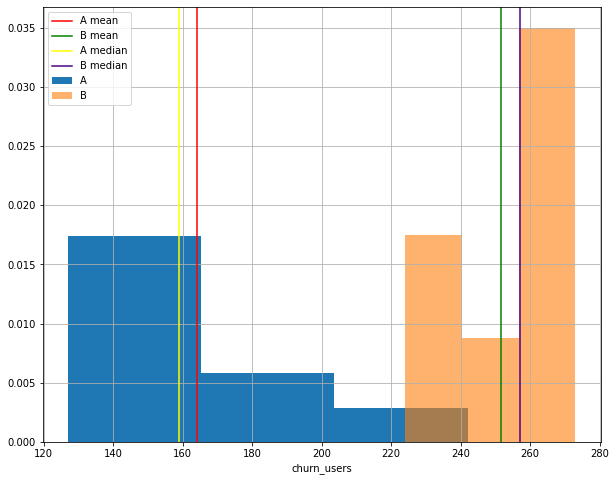

In [ ]:
show_hist(A, B, 'churn_users')

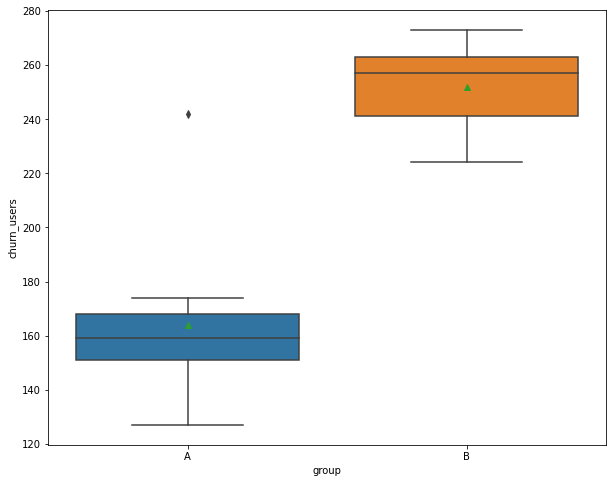

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='group', y='churn_users',
            data=data_bucket, showmeans=True)

In [ ]:
check_normal_kol(A, B, 'churn_users')
check_normal_shapiro(A, B, 'churn_users')

KstestResult(statistic=1.0, pvalue=0.0)
Distribution of control group is not normal

KstestResult(statistic=1.0, pvalue=0.0)
Distribution of test group is not normal
(0.8086885213851929, 0.02564987540245056)
Distributions of control group is not normal

(0.8459286689758301, 0.11276251077651978)
Distributions of test group is normal


Тесты показали нормальность распределения, но если посмотреть на гистограммы, возникают сомнения по этому поводу.
 Поэтому также использовал непараметрический тест Манна-Уитни

In [ ]:
levene_test(A['churn_users'], B['churn_users'])

st = mannwhitneyu(A.churn_users.unique(), B.churn_users.unique())
print(st)
print('Diffs is {}significant\n'.format( {False:'not ',
                                          True:''}[st[1] < alpha]))

Variances of distributions is equal

MannwhitneyuResult(statistic=2.0, pvalue=0.0010714213704518028)
Diffs is significant



In [ ]:
t_st = ttest_ind(A.churn_users, B.churn_users)
print(t_st)
print('Diffs is {}significant\n'.format( {False:'not ',
                                          True:''}[t_st[1] < alpha]))

Ttest_indResult(statistic=-6.3214510835450515, pvalue=1.8862865407437538e-05)
Diffs is significant



T тесть также выдал стат. значимость различий

In [ ]:
print('difference:', np.round(B.churn_users.mean() - A.churn_users.mean()))
print(f'observed effect: {np.round(100 * (B.churn_users.mean() - A.churn_users.mean()) / A.churn_users.mean())} %')

difference: 88.0
observed effect: 53.0 %


Получили статистически значимое увеличение churn_users

2. Кол-во нецелевых сессий

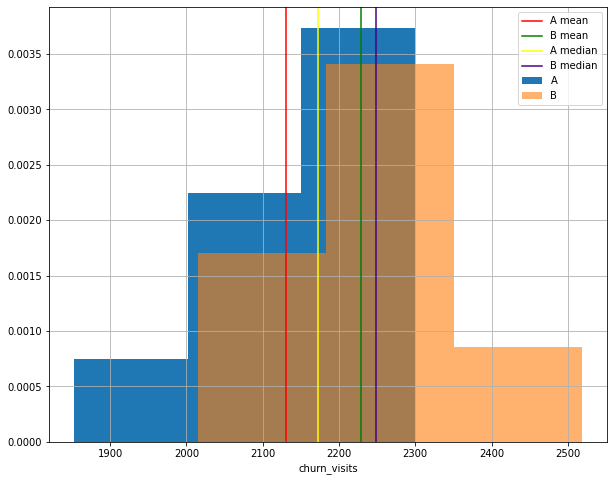

In [ ]:
show_hist(A, B, 'churn_visits')

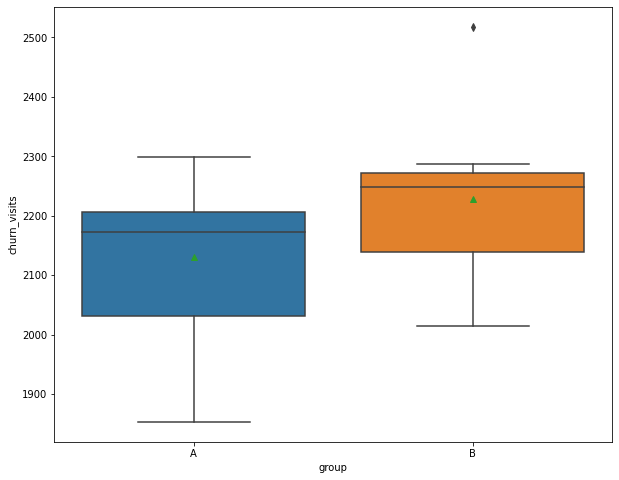

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='group', y='churn_visits',
            data=data_bucket, showmeans=True)

In [ ]:
check_normal_kol(A, B, 'churn_visits')
check_normal_shapiro(A, B, 'churn_visits')

levene_test(A['churn_visits'], B['churn_visits'])

st = mannwhitneyu(A.churn_visits.unique(), B.churn_visits.unique())
print(st)
print('Diffs is {}significant\n'.format( {False:'not ',
                                          True:''}[st[1] < alpha]))

KstestResult(statistic=1.0, pvalue=0.0)
Distribution of control group is not normal

KstestResult(statistic=1.0, pvalue=0.0)
Distribution of test group is not normal
(0.931236982345581, 0.49321380257606506)
Distributions of control group is normal

(0.9275419116020203, 0.5301929712295532)
Distributions of test group is normal
Variances of distributions is equal

MannwhitneyuResult(statistic=20.0, pvalue=0.12213837191163296)
Diffs is not significant



In [ ]:
t_st = ttest_ind(A.churn_visits, B.churn_visits)
print(t_st)
print('Diffs is {}significant\n'.format({False: 'not ',
                                         True: ''}[t_st[1] < alpha]))

Ttest_indResult(statistic=-1.2834338805088847, pvalue=0.22017797308896006)
Diffs is not significant



Различия для churn_visits не стат. значимы

Итак:
* Была замечена неоднозначность данных и даны предполагаемые причины
* Проведен тест для metric_value на пользователя.
    Получен статически значимый прирост в среднем на 7% (на 433)
* Оценены необходимый размер выборки для получения стат. значимых различий и кол-во дней необходимых для этого:  
  сейчас A: 2451, B: 2549  
  effect 7%  
      Нужно набрать: 3205 человек для каждой группы  
      Для контрольной нужно набрать еще: 754  
      Для экспериментальной нужно набрать еще: 656  
      Для нового набора понадобится 18 дней  
      Для  донабора понадобится 3 дней  
  effect 8%  
      Нужно набрать: 2454 человек для каждой группы  
      Для контрольной нужно набрать еще: 3  
      Для нового набора понадобится 14 дней  
      Для  донабора понадобится 1 дней  
  effect 10%  
      Нужно набрать: 1571 человек для каждой группы  
      Для нового набора понадобится 9 дней  
* Проведен тест для churn_users и churn_visits на группу  
  Получили статистически значимое увеличение на 57% количества пользователей, совершавших отказы.  
  Кол-во нецелевых сессий не изменилось

В итоге  
1. из позитивных: увеличение среденего metric_value на пользователя на 7%
2. из негативных: увеличение на 57% среднего кол-ва пользователей на группу, совершавших отказы
